## MovieLens Veri Seti : ml-100k

Kullanacağınız veri seti [buradan](https://grouplens.org/datasets/movielens/100k/) alınmıştır.

Veri setine ait bazı bilgiler: 
-  100.000 puanlama verisi ---> puanlar 1 ile 5 arası 
-  943 kullanıcı ---> kullanıcılardan her biri en az 20 film puanlamış
-  1682 film
-  19 Eylül 1997 - 22 Nisan 1998 arası derlenmiş; MovieLens grup hala veri toplama devam ediyor, daha büyük ve daha güncel veri setleri de mevcut
-  Temizlenmiş, düzenlenmiş, gerçek verilerden oluşan bir veri seti
-  1999 yılında bununla ilgili yayınlanan uluslararası konferans bildirisi : Herlocker, J., Konstan, J., Borchers, A., Riedl, J.. An Algorithmic Framework for Performing Collaborative Filtering. Proceedings of the 1999 Conference on Research and Development in Information Retrieval. Aug. 1999.
-  MovieLens grubu işbirlikçi filtreleme üzerine çalışmalarına devam ediyor


Dosyaların içerikleri (README isimli dosyadan derlenmiştir):

-  ``u.data``: 
    -  kullanıcı - film - puan ilişkisi
    -  user id, movie id, rating, timestamp 

-  ``u.item``: 
    -  item = movie, filmlerle ilgili bilgiler 
    -  movie id, title, release date, video release date, url, 19 sutun ikili tür değişkeni ("unknown" da dahil)    

-  ``u.user``: 
    -  kullanıcıların profili ile ilgili bilgiler 
    -  user id, age, gender, occupation, zip code
        
-  extra dosyalar: 
     - ``u.info``: Veri seti ile ilgili genel bilgiler 
     - ``u.genre``: Filmlerin tür etiketleri ve hangi u.item'de hangi sütuna denk geldikleri  
     - ``u.occupation``: Kullanıcıların meslekleri 
     - ``README``: Veri setini derleyenler tarafından hazırlanmış olan açıklama dosyası
     - ``mku.sh`` ve ``allbut.pl``: Veri setini ve aşağıdaki kümeleri oluşturmak için kullanılan script dosyaları
     - Veri setiyle beraber gelen eğitim ve doğrulama kümeleri:
         -  ``u1.base`` ----- ``u5.test``: 
             - 80% - 20% eğitim ve test kümesi (u.data dosyasından üretilmiş) 
             - dosyaların ortak elemanı yok ---> 5-fold cross-val için uygun 
         -  ``ua.base`` ----- ``ub.test``:  
             - u.data dosyasından eğitim ve test kümesi 
             - test kümesindeki her bir kullanıcı 10 defa puan vermiş (bu kurala uygun düzenlenmiş bir küme)
             - a ve b kümelerinin kesişimi yok

## ========================= u.data =========================

In [100]:
# Kullanacagimiz paketleri (numpy, pandas, matplotlib.pyplot) calisma alanimiza ekleyelim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [101]:
# Elimizdeki verilere bir goz atalim, u.data ile baslayalim

# Veride sutun basliklari yok, once onlara isim verelim
col_names = ['userID', 'movieID', 'score', 'timestamp']

# read_csv fonksiyonunu kullanarak veriyi bir dataframe icerisine yerlestirelim
# ONEMLI: Dosya yoluna, sutun ayraclarina ve dosyalarin encoding'lerine dikkat edin!
df_udata = pd.read_csv('ml-100k/u.data', sep='\t', names = col_names) 

# dataframe'in ilk 10 satirini goruntuleyelim
df_udata.head(10)

,userID,movieID,score,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [102]:
#  Elimizdeki veride hic NaN var mi? isna ile kontrol edelim (NaN varsa True dondurur)
df_udata.isna()

# bir any() daha ekleyerek totale de bakabiliriz ya da toplamini alabiliriz
df_udata.isna().any().any()

False

In [103]:
# Peki dataframe'imimizde bulunan verilerin turleri nelermis? dtypes fonksiyonu ile bakalim
df_udata.dtypes

userID       int64
movieID      int64
score        int64
timestamp    int64
dtype: object

In [104]:
# Hepsi tam sayi gorunuyor, o zaman dataframe'in tanimlayici istatistik degerlerine bakalim...
df_udata.describe()

,userID,movieID,score,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [105]:
# Kac tane unique kullanicimiz varmis? Readme dosyasindan biliyoruz ama kontrol edelim
df_udata['userID'].unique()

# Daha anlasilir bir sekilde goruntulemek icin uzunluguna bakalim
len(df_udata['userID'].unique())

943

In [106]:
# Kac tane unique film mevcut?
len(df_udata.movieID.unique())

1682

In [107]:
# Aslinda burada sadece 'score' sayisal olarak bir sey ifade ediyor, 
# sadece 'score' icin tanimlayici istatistik sonuclarini goruntuleyelim
df_udata.score.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: score, dtype: float64

In [108]:
# Peki puan dagilimlarina bir de biz kendimiz bakalim

# Score degiskeninin min-max (range) degerlerine bakalim, guzelce ekrana bastiralim
print("Min:", df_udata.score.min())
print("Max:", df_udata.score.max())

# Kullanicilarin verdigi puanlarin dagilimina da bir bakalim, aslinda quartile'lardan da anlasiliyor ama 
# value_counts() fonksiyonunu kullanarak 1 puan veren kac kullanici var, 2 puan veren kac kisi var, goruntuleyelim
df_udata.score.value_counts()

Min: 1
Max: 5


4    34174
3    27145
5    21201
2    11370
1     6110
Name: score, dtype: int64

<AxesSubplot: >

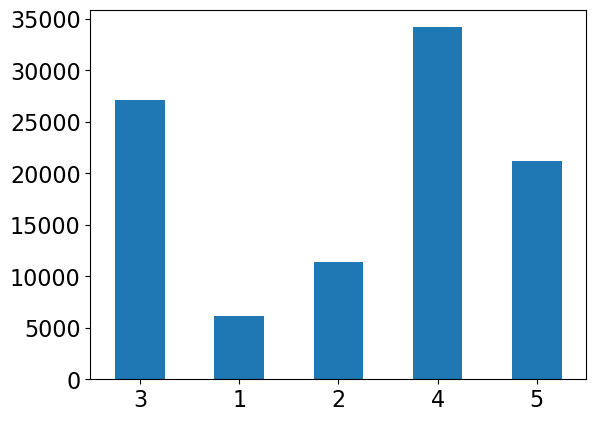

In [109]:
# Siralamaya dikkat! value_counts() fonksiyonunun 'sort' parametresini kullanarak duzeltelim
df_udata.score.value_counts(sort=False).plot(kind='bar', rot=0)

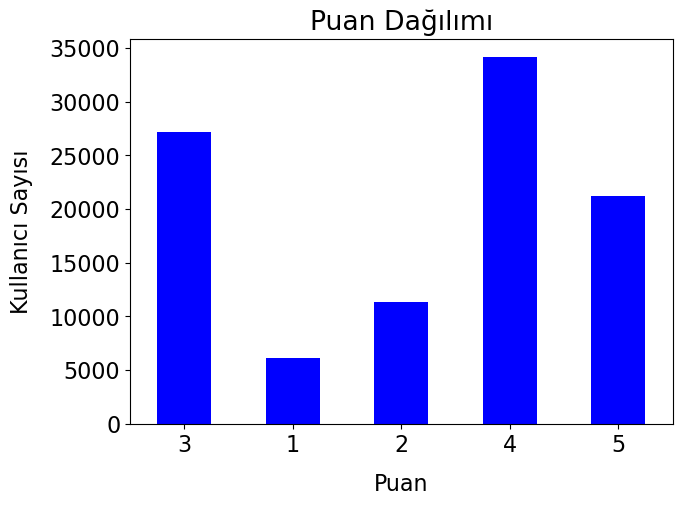

In [110]:
# Yukaridaki grafigi daha goze hitap eder bir hale getirelim

# once figure boyutlarini ayarlayalim
plt.figure(figsize=(7, 5))

# plot fonksiyonunu kullanarak bir bar grafigi cizdirelim
df_udata.score.value_counts(sort=False).plot(kind='bar', color='b', rot=0)

# Plot'un gorsel ozelliklerini duzenleyelim
plt.rc("font", size=16)           # puntoyu buyutelim
plt.title("Puan Dağılımı")        # grafige bir isim verelim
plt.xlabel("Puan", labelpad=12)   # x eksenine isim verelim
plt.ylabel("Kullanıcı Sayısı", labelpad=12); # y eksenine isim verelim

In [111]:
# Simdi de kullanicilar kacar film puanlamislar bir ona bakalim (en az 20 oldugunu biliyoruz)
df_udata.userID.value_counts()

405    737
655    685
13     636
450    540
276    518
      ... 
441     20
36      20
812     20
895     20
93      20
Name: userID, Length: 943, dtype: int64

In [112]:
# Tamam listeledik, ama bir de mode'una bakalım
df_udata.userID.value_counts().mode()

0    20
Name: userID, dtype: int64

In [113]:
# Elimizdeki kullanicilar cogunlukla 20 film puanlamis (---> readme'de belirtilen min sayi)
# Peki en az ve en fazla film puanlayanlar kac defa puan vermis? Yukarida gorduk ama bir de bu sekilde bakalim
print('Min:', df_udata.userID.value_counts().min())
print('Max:', df_udata.userID.value_counts().max())

Min: 20
Max: 737


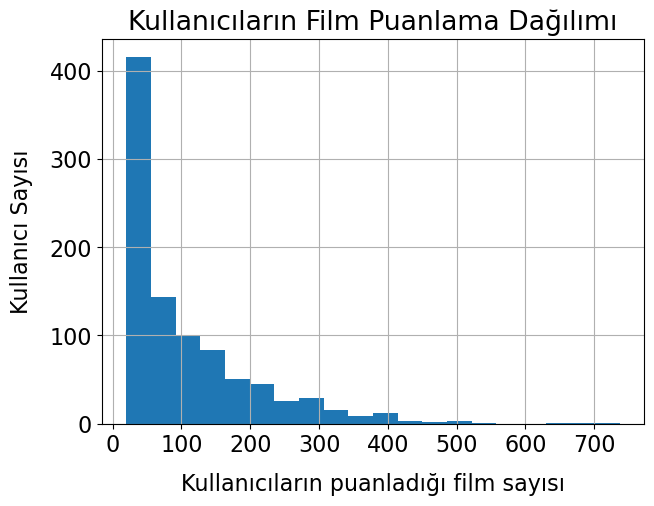

In [114]:
# Bu istatistiklerden yola cikarak aslinda nasil bir dagilim gormemiz lazim? 
# Gorsellestirip bakalim

plt.figure(figsize=(7, 5))

# Bu sefer bar grafigi degil histogram cizmemiz gerekiyor. Neden? (not: bins parametresi ile oynayalim)
df_udata.userID.value_counts().hist(bins=20)

plt.xlabel("Kullanıcıların puanladığı film sayısı",labelpad=12)
plt.ylabel("Kullanıcı Sayısı",labelpad=12)
plt.title("Kullanıcıların Film Puanlama Dağılımı");

In [115]:
# Ayni sekilde, filmlerin cogunlukla kac kullanici tarafindan puanladigina bakalim
df_udata.movieID.value_counts() #.mode()

50      583
258     509
100     508
181     507
294     485
       ... 
852       1
1505      1
1653      1
1452      1
1641      1
Name: movieID, Length: 1682, dtype: int64

In [116]:
# min-max araligina bakalim
print('Min:', df_udata.movieID.value_counts().min())
print('Max:', df_udata.movieID.value_counts().max())

Min: 1
Max: 583


In [117]:
# Filmlerin aldiklari puanlarin ortalamasina ve kac defa puanlandiklarina bir bakalim

# movieID'leri gruplayarak, her bir filmin kullanicilardan aldigi ortalama puani hesaplayalim
# ve yeni bir degiskene atayalim (mean_score)
mean_score = df_udata.groupby('movieID').score.mean()
#print(mean_score)

# yine movieID'leri gruplayarak, her bir filmin kac kullainicidan puan aldigini sayalim (rating_no)
rating_no = df_udata.groupby('movieID').userID.count()
#print(rating_no)

# hepsi birlestirilip yeni bir dataframe olusturalim 
# once dict'i belirleyelim (a = {'xxx': x, 'yyy': y, ...})
m = {'mean_score': mean_score, 'rating_no': rating_no}
# sonra da pandas'ın DataFrame fonksiyonunu kullanalim (df_udata_ort)
df_udata_ort = pd.DataFrame(m)

# olusturdugumuz yeni dataframe'imimizin ilk 10 satirini goruntuleyelim
df_udata_ort.head(20)

,mean_score,rating_no
movieID,,
1,3.878319,452
2,3.206107,131
3,3.033333,90
4,3.550239,209
5,3.302326,86
6,3.576923,26
7,3.798469,392
8,3.995434,219
9,3.896321,299


In [118]:
# Ortalama en yuksek puan neymis? 
df_udata_ort.mean_score.max()

5.0

In [119]:
# loc ile max puan almis filmlere bir bakalim, kac kisi tarafindan puanlanmis?
df_udata_ort.loc[df_udata_ort.mean_score == 5.0]

,mean_score,rating_no
movieID,,
814,5.0,1
1122,5.0,1
1189,5.0,3
1201,5.0,1
1293,5.0,3
1467,5.0,2
1500,5.0,2
1536,5.0,1
1599,5.0,1


In [120]:
# Max puani almis filmlerin en fazla 3 kisi tarafindan oylanmis olmasi biraz acikli
# rating_no sutununun tanimlayici istatistik sonuclarina bakalim
df_udata_ort.rating_no.describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating_no, dtype: float64

In [121]:
# O zaman bir de en fazla oy alan ilk 10 filme bakalim onlar hangileriymis? Nasil bakacagiz? sort_values fonksiyonunu kullanarak...
df_udata_ort.sort_values(['rating_no', 'mean_score'], ascending=False)[:10]

,mean_score,rating_no
movieID,,
50,4.358491,583
258,3.803536,509
100,4.155512,508
181,4.007890,507
294,3.156701,485
286,3.656965,481
288,3.441423,478
1,3.878319,452
300,3.631090,431


##  ========================= u.user =========================

In [122]:
# Bu asamadan sonra artik kontrol sizde... Kolay gelsin :)

In [123]:
#sutunlarda isimler yok, bundan dolayi isim verecegim

col_names_user = ['userID', 'age', 'gender', 'occupation', 'zipCode']

In [124]:
#read_csv fonksiyonu ile verileri bri data frame e yerlestiriyorum

df_user = pd.read_csv('ml-100k/u.user', sep = '|', names = col_names_user)

#son 10 verimize bakalim
df_user.tail(10)

,userID,age,gender,occupation,zipCode
933,934,61,M,engineer,22902
934,935,42,M,doctor,66221
935,936,24,M,other,32789
936,937,48,M,educator,98072
937,938,38,F,technician,55038
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209
942,943,22,M,student,77841


In [125]:
#verimizde null deger var mi?

df_user.isna().any()

userID        False
age           False
gender        False
occupation    False
zipCode       False
dtype: bool

In [126]:
#data frame icindeki verilerinn turlerine bakalim

df_user.dtypes

userID         int64
age            int64
gender        object
occupation    object
zipCode       object
dtype: object

In [127]:
#age kolonunu inceleyelim
df_user.age.describe()

count    943.000000
mean      34.051962
std       12.192740
min        7.000000
25%       25.000000
50%       31.000000
75%       43.000000
max       73.000000
Name: age, dtype: float64

In [128]:
#veri setimizdeki mesleklere bakalim
print(list(df_user.occupation.unique()))
print()
print("Meslek sayisi:",len(df_user.occupation.unique()))

['technician', 'other', 'writer', 'executive', 'administrator', 'student', 'lawyer', 'educator', 'scientist', 'entertainment', 'programmer', 'librarian', 'homemaker', 'artist', 'engineer', 'marketing', 'none', 'healthcare', 'retired', 'salesman', 'doctor']

Meslek sayisi: 21


Text(0.5, 0, 'Occupation')

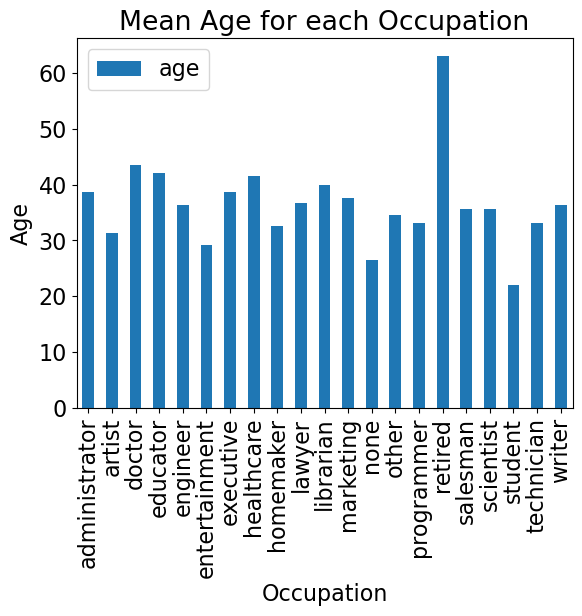

In [129]:
#mesleklerin yas ortalamasina bakalim
df_user[['age','occupation']].groupby('occupation').mean().plot(kind = 'bar', rot = 90)
plt.title('Mean Age for each Occupation')
plt.ylabel('Age')
plt.xlabel('Occupation')

In [130]:
#cinsiyetlere gore verileri inceleyelim
df_user[['age','gender']].groupby('gender').describe()


age                                                    
        count       mean        std   min   25%   50%   75%   max
gender                                                           
F       273.0  33.813187  11.799095  13.0  25.0  32.0  44.0  70.0
M       670.0  34.149254  12.356868   7.0  25.0  31.0  42.0  73.0

In [131]:
#duplike satir var mi ona bakalim
df_user.duplicated().any()

False

In [132]:
#guzel bir isim verelim ve csv olarak kaydedelim
df_user.to_csv('user.csv', index = False )

## ========================= u.item =========================

In [133]:
# Kucuk bir not, burada genelde encoding sorunu oluyor, bunu cozmek icin sunlari yapabilirsiniz:
# 1) u.item dosyasini herhangi bir text editorde acip encoding'ini degistirip tekrar kaydedebilirsiniz
# 2) dosyanin encoding'ini ogrenip asagidaki gibi okuma yapabilirsiniz
col_names_item = ['movie id','movie title','release date','video release date','IMDb URL','unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
df_item = pd.read_csv('ml-100k/u.item', sep='|', encoding = 'latin-1', names = col_names_item) 
df_item.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [134]:
# Bu asamadan sonra artik kontrol sizde... Kolay gelsin :)

In [135]:
#kolon isimlerini gormek istiyorum
df_item.columns

Index(['movie id', 'movie title', 'release date', 'video release date',
       'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [136]:
#bu kolon tamamen bos, bunu ucuralim
df_itemDropped = df_item.drop(columns = ['video release date'])

In [137]:
#bu iki kolonda bos veriler var
df_itemDropped.isna().any()

movie id        False
movie title     False
release date     True
IMDb URL         True
unknown         False
Action          False
Adventure       False
Animation       False
Childrens       False
Comedy          False
Crime           False
Documentary     False
Drama           False
Fantasy         False
Film-Noir       False
Horror          False
Musical         False
Mystery         False
Romance         False
Sci-Fi          False
Thriller        False
War             False
Western         False
dtype: bool

In [138]:
#kac tane veri bos, silmeden once buna bakalim
df_itemDropped[df_itemDropped.isna().any(axis=1)]
#hepi topu 3 satir, bunlari ucuralim

,movie id,movie title,release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaN,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1357,1358,The Deadly Cure (1996),16-Sep-1996,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1358,1359,Boys in Venice (1996),24-Sep-1996,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
#ucurduk
df_itemDroppedDropped = df_itemDropped.dropna()

In [140]:
#kontrol edelim, OKB'li arkadaslari sinir stres etmeyelim
df_itemDroppedDropped.isna().any()
#umarim dropun dropunun dropu olmaz :( 

movie id        False
movie title     False
release date    False
IMDb URL        False
unknown         False
Action          False
Adventure       False
Animation       False
Childrens       False
Comedy          False
Crime           False
Documentary     False
Drama           False
Fantasy         False
Film-Noir       False
Horror          False
Musical         False
Mystery         False
Romance         False
Sci-Fi          False
Thriller        False
War             False
Western         False
dtype: bool

In [141]:
#duplike yok
df_itemDroppedDropped.duplicated().any()

False

In [142]:
print(df_itemDropped.shape)


(1682, 23)


In [143]:
df_itemDroppedDropped.to_csv('item.csv', index = False)

In [144]:
df_itemFinal = df_itemDroppedDropped

In [145]:
df_itemFinal

,movie id,movie title,release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# ================================= #
### Burdan sonra data ve item tablolarini movieID PK'si uzerinden birlestirdim

In [146]:
df_merge = df_udata.merge(df_itemDroppedDropped, left_on='movieID', right_on='movie id')

In [147]:
# Isimlendirmeler sacma oldu ama sadece gerekli kolonlari gormek istedim su an bu 
# dataframe uzerinden guzel analizler yapabilecegime inaniyorum
df_merge1 = df_merge[['userID','movie title', 'score', 'release date', 'IMDb URL']]

In [148]:
df_merge1

,userID,movie title,score,release date,IMDb URL
0,196,Kolya (1996),3,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)
1,63,Kolya (1996),3,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)
2,226,Kolya (1996),5,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)
3,154,Kolya (1996),3,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)
4,306,Kolya (1996),5,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)
...,...,...,...,...,...
99982,840,Mamma Roma (1962),4,01-Jan-1962,http://us.imdb.com/M/title-exact?Mamma%20Roma%...
99983,655,"Eighth Day, The (1996)",3,01-Nov-1996,"http://us.imdb.com/Title?Huiti%E8me+jour,+Le+(..."
99984,655,Girls Town (1996),3,23-Aug-1996,http://us.imdb.com/M/title-exact?Girls%20Town%...
99985,655,"Silence of the Palace, The (Saimt el Qusur) (1...",3,02-Feb-1996,http://us.imdb.com/M/title-exact?Saimt%20el%20...


In [149]:
df_meanScore = df_merge1[['movie title','score']].groupby('movie title').mean().copy()

In [150]:
df_meanScore

,score
movie title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390
...,...
Young Guns (1988),3.207921
Young Guns II (1990),2.772727
"Young Poisoner's Handbook, The (1995)",3.341463


(1) Ortalama puanı 4'ün üzerinde olan filmlerin movieID'lerini bulun.

In [151]:
# henuz pandas syntax'ina pek hakim olmadigim icin 
#puzzle cozer gibi sonuca ulastim eminim cok basit bir cevabi vardir ama
#benim izledigim yol biraz karisik oldu
df_meanScore.where(df_meanScore.score > 4).dropna()

,score
movie title,
12 Angry Men (1957),4.344000
"39 Steps, The (1935)",4.050847
A Chef in Love (1996),4.125000
"Affair to Remember, An (1957)",4.192308
"African Queen, The (1951)",4.184211
...,...
Wallace & Gromit: The Best of Aardman Animation (1996),4.447761
When We Were Kings (1996),4.045455
"Wild Bunch, The (1969)",4.023256


(2) Kullanıcılar tarafından en çok oylanan (puan verilen) 10 filmin movieID'lerini bulun. 

In [152]:
# Ya bunun kesin cok kolay bi yolu vardir
df_merge1.groupby(['movie title'])['movie title'].count().sort_values().tail(10)

movie title
Independence Day (ID4) (1996)    429
Air Force One (1997)             431
Toy Story (1995)                 452
Scream (1996)                    478
English Patient, The (1996)      481
Liar Liar (1997)                 485
Return of the Jedi (1983)        507
Fargo (1996)                     508
Contact (1997)                   509
Star Wars (1977)                 583
Name: movie title, dtype: int64

(3) Veri setinde kaç kadın kaç erkek kullanıcı bulunduğunu görselleştirin. 

<AxesSubplot: xlabel='gender'>

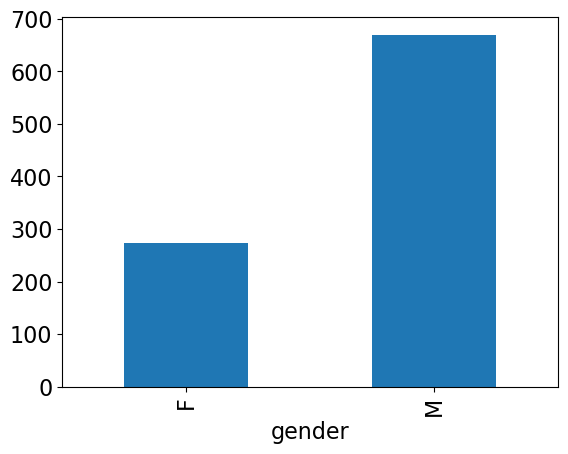

In [153]:
#tamam bu kod daha az amele oldu bence
df_user.groupby(['gender'])['gender'].count().plot(kind = 'bar')

(4) Veri setinde en çok hangi meslek grubundan kullanıcılar mevcut?

In [154]:
df_user.groupby(['occupation'])['occupation'].count()


occupation
administrator     79
artist            28
doctor             7
educator          95
engineer          67
entertainment     18
executive         32
healthcare        16
homemaker          7
lawyer            12
librarian         51
marketing         26
none               9
other            105
programmer        66
retired           14
salesman          12
scientist         31
student          196
technician        27
writer            45
Name: occupation, dtype: int64

(5) Kullanıcıların meslek gruplarına göre dağılımlarını görselleştirin.

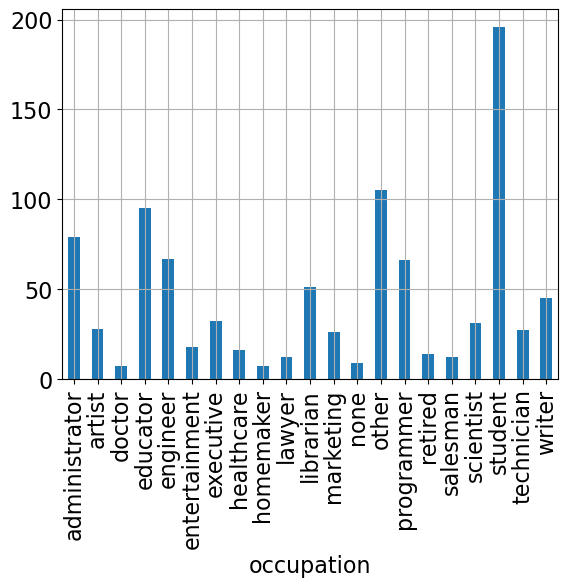

In [155]:
#bu kolay oldu
df_user.groupby(['occupation'])['occupation'].count().plot(kind= 'bar').grid()

(6) Veri setinde en çok hangi türde filmler bulunuyor?

In [156]:
#Omru hayatimda boyle bir amelelik gormedim ben
import collections

dicts = {}

for i in df_itemDroppedDropped[['unknown', 'Action', 'Adventure', 'Animation', 'Childrens',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western']]:
    dicts[i] = len(df_itemDroppedDropped[df_itemDroppedDropped[i] == 1])

collections.OrderedDict(sorted(dicts.items()))



OrderedDict([('Action', 250),
             ('Adventure', 135),
             ('Animation', 42),
             ('Childrens', 122),
             ('Comedy', 505),
             ('Crime', 109),
             ('Documentary', 50),
             ('Drama', 724),
             ('Fantasy', 22),
             ('Film-Noir', 24),
             ('Horror', 92),
             ('Musical', 56),
             ('Mystery', 61),
             ('Romance', 247),
             ('Sci-Fi', 101),
             ('Thriller', 251),
             ('War', 71),
             ('Western', 27),
             ('unknown', 1)])

(7) Veri setindeki filmlerin tür dağılımlarını görselleştirin.

(8) Ortalama puanı en yüksek ve en az 100 kişi tarafından oylanmış olan ilk 25 filmi bulun.

(9) Bir kaç tane yaş grubu belirleyin, veritabanındaki filmlerin belirlediğiniz yaş gruplarına ait kullanıcılar tarafından ortalama kaç puan aldıklarını hesaplayın. 

(10) Veritabanındaki filmlerin kadın ve erkek kullanıcılar tarafından ortalama kaç puan aldıklarını hesaplayın. Arada en yüksek puan farkının bulunduğu filmler hangileriymiş görüntüleyin. 

## Model denemeleri


In [157]:
df_udata.head()

,userID,movieID,score,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [158]:
#df_user.head()
df_data_user = df_udata.merge(df_user, left_on='userID', right_on='userID')

df_data_user_item = df_data_user.merge(df_itemFinal, left_on='movieID', right_on='movie id')



In [159]:
df_itemFinal.head()

,movie id,movie title,release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [160]:
df_merge1.head()

,userID,movie title,score,release date,IMDb URL
0,196,Kolya (1996),3,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)
1,63,Kolya (1996),3,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)
2,226,Kolya (1996),5,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)
3,154,Kolya (1996),3,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)
4,306,Kolya (1996),5,24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996)


In [161]:
dataframe_ann = df_data_user_item[['occupation','age', 'gender','unknown', 'Action', 'Adventure', 'Animation', 'Childrens','Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir','Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War','Western','score']]

In [162]:
dataframe_ann.to_csv('df_ann.csv', index = False)
dataframe_ann


,occupation,age,gender,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
0,writer,49,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
1,programmer,23,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5
2,executive,42,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
3,retired,60,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
4,marketing,31,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99982,student,17,M,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,3
99983,student,17,M,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99984,student,17,M,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
99985,writer,28,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3


In [163]:
dataframe_ann[dataframe_ann.isna().any(axis=1)]

,occupation,age,gender,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score


In [164]:
dataframe_ann = dataframe_ann.dropna()

In [165]:
X = dataframe_ann.iloc[:,1:23].values
y = dataframe_ann.iloc[:, 0].values

Ben burda feature secerken sayisal olan ve kategorik olup encode edilebilecek kolonlari sectim mesela gender label encode edilebilir occupation one hot encode edilebilir. ID Name gibi verileri secmedim cunku build edecegim yapay beyin icin bu tarz veriler analiz yapabilmek icin pek de anlami olmaz.

In [166]:
#Gender encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 1] = le.fit_transform(X[:, 1])

In [167]:
#One hot encoding for occupation
y = pd.get_dummies(y)

In [168]:
dataframe_ann[0:20]

,occupation,age,gender,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
0,writer,49,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
1,programmer,23,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5
2,executive,42,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
3,retired,60,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
4,marketing,31,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
5,executive,26,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,writer,27,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
7,student,25,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5
8,educator,47,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
9,programmer,33,M,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3


In [169]:
X

array([[49, 1, 0, ..., 0, 0, 3],
       [23, 1, 0, ..., 0, 0, 5],
       [42, 1, 0, ..., 0, 0, 4],
       ...,
       [17, 1, 0, ..., 0, 0, 2],
       [28, 1, 0, ..., 0, 0, 3],
       [27, 1, 0, ..., 0, 0, 3]], dtype=object)

In [170]:
#burda y yi dataframe den array e cevirdim
y = y.iloc[:, 0].values
y

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [171]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [172]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Building the ANN

ben bu kodlari colab de calsitirabiliyorum ve dogruluk orani %92 ile sonuclaniyor fakat jupyter de calismiyor... duzeltme calisiyor ama cok gec calisiyor :DDD

In [173]:
ann = tf.keras.models.Sequential()
print("deneme")

deneme


In [174]:
#First hidden layer with 45 neurons
ann.add(tf.keras.layers.Dense(units = 45, activation = 'sigmoid'))

In [175]:
#output layer
ann.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

In [176]:
ann.compile(optimizer = 'adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

In [177]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [178]:
ann.fit(X_train, y_train, batch_size= 256, epochs = 100)

Epoch 1/100
313/313 [==============================] - 1s 1ms/step - loss: 0.2800 - accuracy: 0.9254
Epoch 2/100
313/313 [==============================] - 0s 1ms/step - loss: 0.2538 - accuracy: 0.9246
Epoch 3/100
313/313 [==============================] - 0s 1ms/step - loss: 0.2515 - accuracy: 0.9253
Epoch 4/100
313/313 [==============================] - 0s 1ms/step - loss: 0.2573 - accuracy: 0.9230
Epoch 5/100
313/313 [==============================] - 0s 1ms/step - loss: 0.2520 - accuracy: 0.9250
Epoch 6/100
313/313 [==============================] - 0s 1ms/step - loss: 0.2550 - accuracy: 0.9238
Epoch 7/100
313/313 [==============================] - 0s 1ms/step - loss: 0.2551 - accuracy: 0.9237
Epoch 8/100
313/313 [==============================] - 0s 1ms/step - loss: 0.2496 - accuracy: 0.9255
Epoch 9/100
313/313 [==============================] - 1s 2ms/step - loss: 0.2519 - accuracy: 0.9249
Epoch 10/100
313/313 [==============================] - 0s 1ms/step - loss: 0.2529 - accura

In [179]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred = np.asarray(y_pred).astype(np.float32)

In [180]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 1.]
 [0. 0.]]


In [181]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
#print(cm)
accuracy_score(y_test, y_pred)*100

92.58425842584258